<a href="https://colab.research.google.com/github/lenessvi/zadaniya-/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas scikit-learn seaborn scipy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [4]:
# Загрузка набора данных
df = pd.read_csv('/content/drive/MyDrive/employee.csv')

In [5]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1
14995,0.37,0.48,2,160,3,0,0,support,low,1
14996,0.37,0.53,2,143,3,0,0,support,low,1
14997,0.11,0.96,6,280,4,0,0,support,low,1


In [6]:
df['rich_people'] = np.where(df['salary'] == 'high', 1, 0)
df.rich_people = df.rich_people.astype('category')
df['department'] = df['department'].astype('category')

In [7]:
Y = df['rich_people'] # выбираем целевую переменную (категориальную)
X = df.drop('rich_people', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('salary', axis=1)

In [8]:
df.drop('salary', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     14999 non-null  float64 
 1   last_evaluation        14999 non-null  float64 
 2   number_project         14999 non-null  int64   
 3   average_montly_hours   14999 non-null  int64   
 4   time_spend_company     14999 non-null  int64   
 5   Work_accident          14999 non-null  int64   
 6   promotion_last_5years  14999 non-null  int64   
 7   department             14999 non-null  category
 8   left                   14999 non-null  int64   
 9   rich_people            14999 non-null  category
dtypes: category(2), float64(2), int64(6)
memory usage: 967.3 KB


In [9]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left,rich_people
0,0.38,0.53,2,157,3,0,0,sales,low,1,0
1,0.80,0.86,5,262,6,0,0,sales,medium,1,0
2,0.11,0.88,7,272,4,0,0,sales,medium,1,0
3,0.72,0.87,5,223,5,0,0,sales,low,1,0
4,0.37,0.52,2,159,3,0,0,sales,low,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1,0
14995,0.37,0.48,2,160,3,0,0,support,low,1,0
14996,0.37,0.53,2,143,3,0,0,support,low,1,0
14997,0.11,0.96,6,280,4,0,0,support,low,1,0


## 2: масштабирование признаков

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     14999 non-null  float64 
 1   last_evaluation        14999 non-null  float64 
 2   number_project         14999 non-null  int64   
 3   average_montly_hours   14999 non-null  int64   
 4   time_spend_company     14999 non-null  int64   
 5   Work_accident          14999 non-null  int64   
 6   promotion_last_5years  14999 non-null  int64   
 7   department             14999 non-null  category
 8   left                   14999 non-null  int64   
dtypes: category(1), float64(2), int64(6)
memory usage: 952.6 KB


In [11]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [12]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,1,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,1,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,1,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,1,False,False,False,False,False,False,False,True,False
14995,0.37,0.48,2,160,3,0,0,1,False,False,False,False,False,False,False,True,False
14996,0.37,0.53,2,143,3,0,0,1,False,False,False,False,False,False,False,True,False
14997,0.11,0.96,6,280,4,0,0,1,False,False,False,False,False,False,False,True,False


In [13]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [14]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.318681,0.265625,2,157,3,0,0,1,False,False,False,False,False,False,True,False,False
1,0.780220,0.781250,5,262,6,0,0,1,False,False,False,False,False,False,True,False,False
2,0.021978,0.812500,7,272,4,0,0,1,False,False,False,False,False,False,True,False,False
3,0.692308,0.796875,5,223,5,0,0,1,False,False,False,False,False,False,True,False,False
4,0.307692,0.250000,2,159,3,0,0,1,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,2,151,3,0,0,1,False,False,False,False,False,False,False,True,False
14995,0.307692,0.187500,2,160,3,0,0,1,False,False,False,False,False,False,False,True,False
14996,0.307692,0.265625,2,143,3,0,0,1,False,False,False,False,False,False,False,True,False
14997,0.021978,0.937500,6,280,4,0,0,1,False,False,False,False,False,False,False,True,False


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [15]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [16]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.9185
Точность на тестовой выборке: 0.9193

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2753
           1       0.86      0.02      0.05       247

    accuracy                           0.92      3000
   macro avg       0.89      0.51      0.50      3000
weighted avg       0.91      0.92      0.88      3000



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [17]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [18]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [19]:
X_processed.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.273220,0.267452,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.000000,0.000000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [20]:
X_iqr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.0,8940.0,8940.0
mean,0.634582,0.555535,3.788814,199.163535,3.169463,0.0,0.0,0.0
std,0.238447,0.252974,0.976699,45.510805,1.131289,0.0,0.0,0.0
min,0.032967,0.000000,2.000000,96.000000,2.000000,0.0,0.0,0.0
25%,0.494505,0.343750,3.000000,162.000000,2.000000,0.0,0.0,0.0
50%,0.659341,0.546875,4.000000,198.000000,3.000000,0.0,0.0,0.0
75%,0.824176,0.765625,4.000000,238.000000,4.000000,0.0,0.0,0.0
max,1.000000,1.000000,6.000000,287.000000,7.000000,0.0,0.0,0.0


In [21]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.9045
Точность на тестовой выборке: 0.9044

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1617
           1       0.00      0.00      0.00       171

    accuracy                           0.90      1788
   macro avg       0.45      0.50      0.47      1788
weighted avg       0.82      0.90      0.86      1788



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression(max_iter=1000)

### ⏰ **При любых коэфицентах уменьшают точность :(**

### Метод 2: удаление на основе среднего

In [22]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=4):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [23]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [24]:
X_processed.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.273220,0.267452,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.000000,0.000000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [25]:
X_mean.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.00000,14482.0,14482.000000
mean,0.572750,0.556319,3.805621,201.104958,3.394628,0.14121,0.0,0.245270
std,0.274354,0.267820,1.239717,50.017988,1.227567,0.34825,0.0,0.430262
min,0.000000,0.000000,2.000000,96.000000,2.000000,0.00000,0.0,0.000000
25%,0.384615,0.312500,3.000000,156.000000,3.000000,0.00000,0.0,0.000000
50%,0.604396,0.562500,4.000000,200.000000,3.000000,0.00000,0.0,0.000000
75%,0.802198,0.796875,5.000000,245.000000,4.000000,0.00000,0.0,0.000000
max,1.000000,1.000000,7.000000,310.000000,8.000000,1.00000,0.0,1.000000


In [26]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.9230
Точность на тестовой выборке: 0.9230

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2674
           1       0.00      0.00      0.00       223

    accuracy                           0.92      2897
   macro avg       0.46      0.50      0.48      2897
weighted avg       0.85      0.92      0.89      2897



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression(max_iter=1000)

### ⏰ **О ура-ура точность выросла!!!!**

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression


In [83]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=6)
X_kbest = selector.fit_transform(X_processed, Y)


In [84]:
selector.scores_

array([1.32477385e+01, 6.38421079e+00, 1.14207996e+00, 7.56310040e-01,
       2.39766784e+01, 1.22561474e+00, 8.88783038e+01, 2.22570006e+02,
       3.42709484e+00, 2.09602753e+00, 4.78416854e+00, 6.85532753e+02,
       1.39440719e+00, 6.36429155e-01, 2.31660503e+01, 1.27835715e+01,
       3.22891150e+00])

In [85]:
X_processed.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'left', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical'],
      dtype='object')

In [86]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.318681,0.265625,2,157,3,0,0,1,False,False,False,False,False,False,True,False,False
1,0.780220,0.781250,5,262,6,0,0,1,False,False,False,False,False,False,True,False,False
2,0.021978,0.812500,7,272,4,0,0,1,False,False,False,False,False,False,True,False,False
3,0.692308,0.796875,5,223,5,0,0,1,False,False,False,False,False,False,True,False,False
4,0.307692,0.250000,2,159,3,0,0,1,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,2,151,3,0,0,1,False,False,False,False,False,False,False,True,False
14995,0.307692,0.187500,2,160,3,0,0,1,False,False,False,False,False,False,False,True,False
14996,0.307692,0.265625,2,143,3,0,0,1,False,False,False,False,False,False,False,True,False
14997,0.021978,0.937500,6,280,4,0,0,1,False,False,False,False,False,False,False,True,False


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [87]:
selector.get_support(indices=True)

array([ 0,  4,  6,  7, 11, 14])

In [88]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['satisfaction_level', 'time_spend_company', 'promotion_last_5years',
       'left', 'department_management', 'department_sales'],
      dtype='object')


In [89]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.9188
Точность на тестовой выборке: 0.9190

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2753
           1       0.75      0.02      0.05       247

    accuracy                           0.92      3000
   macro avg       0.83      0.51      0.50      3000
weighted avg       0.91      0.92      0.88      3000



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [97]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=4)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['promotion_last_5years', 'left', 'department_accounting',
       'department_management'],
      dtype='object')


In [98]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.9191
Точность на тестовой выборке: 0.9193

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2753
           1       0.78      0.03      0.05       247

    accuracy                           0.92      3000
   macro avg       0.85      0.51      0.51      3000
weighted avg       0.91      0.92      0.88      3000



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-1.86869457e-01 -3.32537962e-01 -3.33847428e-02  6.02483493e-04
   5.40551104e-02 -1.25927434e-01  5.83697041e-01 -1.57047049e+00
  -1.67556092e-01  3.73237515e-01 -9.33056288e-02  1.83820043e+00
   2.81083539e-01  7.33465972e-02 -8.37246045e-02 -7.74221114e-02
   1.00936312e-01]]
Коэффициенты модели с регуляризацией: [[-2.02786269e-01 -3.24585388e-01 -3.69577852e-02  4.60767719e-04
   5.15452371e-02 -1.20458210e-01  5.75100136e-01 -1.58090035e+00
  -1.44674696e-01  3.72227169e-01 -6.55799142e-02  1.85482881e+00
   2.77793935e-01  6.94502867e-02 -7.23205491e-02 -6.01777055e-02
   9.83658042e-02]]
Отобранные признаки: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'left', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'depart

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


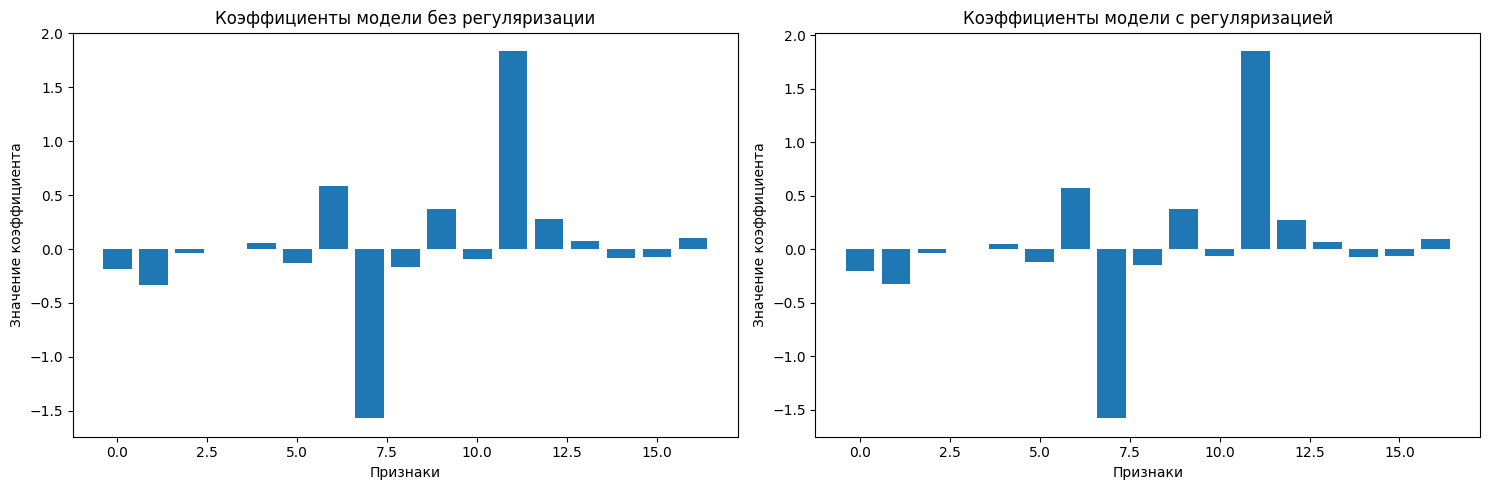

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [39]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.9185
Точность на тестовой выборке: 0.9193

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2753
           1       0.86      0.02      0.05       247

    accuracy                           0.92      3000
   macro avg       0.89      0.51      0.50      3000
weighted avg       0.91      0.92      0.88      3000



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**
 в filter и wrapper нашла k, но изменения дали не большой результат, разница меньше 0,1. в embedded ниче не поняла, k не нашла

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

# **SequentialFeatureSelector**
SequentialFeatureSelector — это метод отбора признаков, выполняющий последовательное добавление или удаление признаков для улучшения точности модели.
**SequentialFeatureSelector может работать двумя способами:**

*   Прямой отбор (forward): Начинается с пустого набора признаков, добавляя по  одному наиболее значимому признаку до достижения заданного размера набора или выполнения критерия остановки.
*   Обратный отбор (backward): Начинается с полного набора признаков, удаляя по одному наименее значимому до выполнения условия остановки.

**Сравнение с предыдущими методами**
*   Методы фильтрации (например, удаление признаков по среднему или медиане:
Оценивают признаки по их статистическим характеристикам, не принимая во внимание влияние на модель и взаимодействия между признаками.
*   SequentialFeatureSelector:
Оценивает комбинации признаков с учетом их влияния на модель, обеспечивая более точные результаты за счет учета взаимодействий между ними.

**Объяснение результатов**

Улучшение точности на тестовой выборке: SequentialFeatureSelector позволяет выбрать более значимые признаки, что способствует улучшению обобщающей способности модели.



## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [99]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [100]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [101]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [111]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.9190613093253306
Точности по каждому фолду: [0.917, 0.925, 0.9153333333333333, 0.9183333333333333, 0.9196398799599866]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Средняя точность: 0.919: Это среднее значение точности, полученное после проведения всех
𝐾
K итераций. Оно показывает общее качество модели и её способность обобщать данные. Значение 0.919 указывает на то, что модель хорошо справляется с задачей и делает правильные прогнозы в среднем в 91.9% случаев.

Точности по каждому фолду: [0.917, 0.925, 0.915, 0.918, 0.920]: Эти значения представляют точность на каждом отдельном фолде. Видно, что точности не сильно различаются между фолдами, что указывает на стабильность модели. Это говорит о том, что модель демонстрирует похожую производительность на различных подвыборках данных и нет значительного переобучения или недообучения.

In [115]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=6, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.9182222222222222
Точности по каждому разделению: [0.9175, 0.9191666666666667, 0.9175, 0.9165, 0.9171666666666667, 0.9215]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Средняя точность: 0.918: Это средняя точность модели, вычисленная по всем случайным разделениям данных. Значение 0.918 указывает на то, что модель показывает хорошее качество предсказаний и правильна в среднем в 91.8% случаев.

Точности по каждому разделению: [0.9175, 0.9192, 0.9175, 0.9165, 0.9172, 0.9215]:

Точности по отдельным итерациям находятся в довольно узком диапазоне (от 0.9165 до 0.9215). Это указывает на то, что модель демонстрирует устойчивую производительность при различных разделениях данных.
Небольшие колебания между точностями показывают, что модель стабильно справляется с предсказаниями, и её результаты не сильно зависят от случайного выбора тренировочной и тестовой выборок.

In [104]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.9166666666666666
Точность на тестовых данных: 0.9175


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
Точность на валидационных данных: 0.917:
Это показатель того, как модель работает на данных, которые были отложены для финальной проверки после тренировки и тестирования. Значение 0.917 указывает на хорошую обобщающую способность модели и подтверждает её способность предсказывать на новых, ранее невидимых данных.
Точность на тестовых данных: 0.9175:
Это метрика, полученная при оценке модели на тестовой выборке, которая использовалась для проверки её производительности после обучения. Похожее значение (0.9175) указывает на то, что модель стабильна и хорошо работает на разных частях данных.

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**
K-fold Cross-Validation подходит больше всего, так как датасет небольшой и точность в нем самая высокая